<a href="https://colab.research.google.com/github/Justin-Jonany/SciDigest/blob/main/1_scidigest_eda_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SciDigest**
With the growth of many fields, more papers are published annually. Researchers need to find sources for their research, so abstracts are really helpful. However, reading through hundreds of unstructured abstracts is time-consuming and irritating.

**SciDigest** is a deep learning model that aims to help people, especially researchers, to digest abstracts better. This model receives abstracts as inputs and turn it into a structured abstract.

**SciDigest** will be trained on [PubMed 200k and 20k RCT dataset](https://github.com/Franck-Dernoncourt/pubmed-rct).

Some of the model architecture will be referenced and based on:
* [Paper 1](https://arxiv.org/pdf/1710.06071.pdf)
* [Paper 2](https://arxiv.org/pdf/1612.05251.pdf)

**Note:**
Through this notebook and other notebooks, these papers will be referred as **[Paper 1](https://arxiv.org/pdf/1710.06071.pdf)** and **[Paper 2](https://arxiv.org/pdf/1612.05251.pdf)**

## Goal
The goal of this project:
1. Replicate the model architecture in **Paper 2**
2. Beat the F1-Score of the model in **Paper 1**, that is **91.6**


## Notebook Goal
This notebook aims to:
1. Get, explore, and analyze the data
2. Preprocess the data and format it into the correct format

**Note:**
Batching the data would be done directly when creating the model, since a lot of the models that's going to made require different formats of data.

## Libraries

In [ ]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import random
import zipfile

## Helper Function

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  '''
  Reads filenames (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line form the target filename.
  '''

  with open(filename, 'r') as f:
    return f.readlines()

def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = '' # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith('###'): # check to see if the line is an ID line
      abstract_id = line
      abstract_lines = '' # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split('\t') # split target label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract?
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there i the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract sample list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

def split_chars(text):
  '''
  Adds a space (' ') in between every character in text
  '''
  return " ".join(list(text))

def save_data(data_list, parent_dir, data_name, data_types):
  '''
  Saves all data in data_list in parent_dir + data_name with the name data_types
  '''
  os.makedirs(os.path.join(parent_dir, data_name), exist_ok=True)
  for data, data_type in zip(data_list, data_types):
    data.to_csv(os.path.join(parent_dir, data_name, data_type + '.csv'))


## Getting Dataset

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 3.91 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## **20K RCT** dataset

Using the PubMed 20k RCT with numbers replace with '@' sign

### EDA and Preprocessing

In this section, I'm going to create:
1. General dataset
2. List of sentences
3. List of sentences with characters split with ' ' (whitespace)
4. List of numeric labels
  * One-hot-encoded
  * Label-enocded
5. One-hot-encoded of feature-engineered features
  * Line numbers
  * Total lines

In [ ]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
!head -n 26 /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt

###24293578
OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .
METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .
METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .
METHODS	Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP 

#### 1. General Dataset

In [ ]:
train_lines = get_lines(data_dir + 'train.txt') # read the lines with the training file
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Formatting the text into a list of dictionary for each sentence
```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
   'total_lines: 11'},
   ...]
```

In [ ]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt') # dev is another name for validation data
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


The dataframe above represents how a single abstract can be represented

In [ ]:
# Distribution of labels in training data
distribution = train_df.target.value_counts()
distribution

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

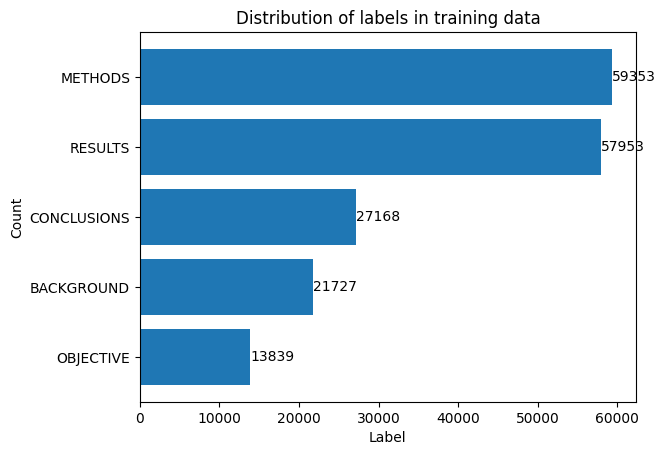

In [ ]:
barh = plt.barh(distribution.index, distribution.values)
plt.title('Distribution of labels in training data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.gca().invert_yaxis()
plt.bar_label(barh)
plt.show();

#### 2. List of Sentences

In [ ]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

#### 3. List of sentences with characters split with ' ' (whitespace)

In [ ]:
random_train_sentence = random.choice(train_sentences)
random_train_sentence

'the most commonly occurring aes were gastrointestinal disorders , abnormal laboratory values , and increased or decreased biochemistry and/or hematology values , as well as headaches , which occurred at a slightly higher frequency in the emd @ group compared with placebo .'

In [ ]:
split_chars(random_train_sentence)

't h e   m o s t   c o m m o n l y   o c c u r r i n g   a e s   w e r e   g a s t r o i n t e s t i n a l   d i s o r d e r s   ,   a b n o r m a l   l a b o r a t o r y   v a l u e s   ,   a n d   i n c r e a s e d   o r   d e c r e a s e d   b i o c h e m i s t r y   a n d / o r   h e m a t o l o g y   v a l u e s   ,   a s   w e l l   a s   h e a d a c h e s   ,   w h i c h   o c c u r r e d   a t   a   s l i g h t l y   h i g h e r   f r e q u e n c y   i n   t h e   e m d   @   g r o u p   c o m p a r e d   w i t h   p l a c e b o   .'

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

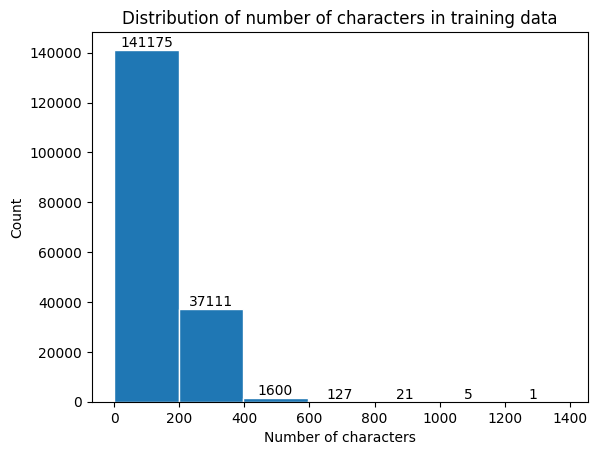

In [ ]:
values, bins, bars = plt.hist(char_lens, bins=7, edgecolor='white');
plt.title('Distribution of number of characters in training data')
plt.xlabel('Number of characters')
plt.ylabel('Count')
plt.bar_label(bars)
plt.show();


In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

#### 4. List of numeric labels

##### a. One-hot-encoding

In [ ]:
one_hot_encoder = OneHotEncoder(sparse_output=False) # We want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))


# Check what one hot encodd labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

##### b. Label-encoded

In [ ]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# check what training labels look like
train_labels_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

#### 5. One-hot-encoded of feature-engineered features
The data is already feature-engineered with line number and total number of lines. Let's one hot encode them.

However, one-hot-encoding is very inefficient since it increases the size of the data a lot. Therefore, let's adjust the depth of the one-hot encoding to gather 98% of the data.*italicized text*

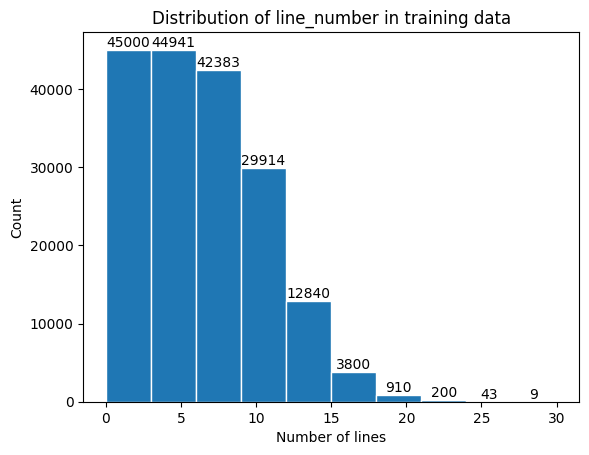

In [ ]:
# Check the distribution of 'line_number' column
values, bins, bars = plt.hist(train_df.line_number, edgecolor='white')
plt.title('Distribution of line_number in training data')
plt.xlabel('Number of lines')
plt.ylabel('Count')
plt.bar_label(bars)
plt.show();

In [ ]:
print(f'To get 95% of data we need to categorize the data to {int(np.percentile(train_df.line_number, 95))} categories')
print(f'To get 97% of data we need to categorize the data to {int(np.percentile(train_df.line_number, 97))} categories')
print(f'To get 98% of data we need to categorize the data to {int(np.percentile(train_df.line_number, 98))} categories')

To get 95% of data we need to categorize the data to 13 categories
To get 97% of data we need to categorize the data to 14 categories
To get 98% of data we need to categorize the data to 15 categories


In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape


(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

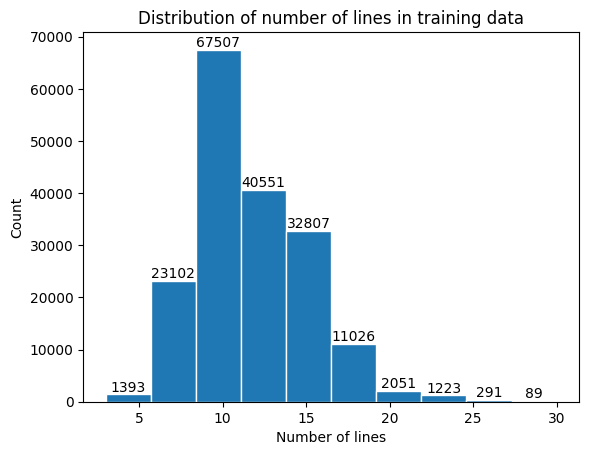

In [ ]:
# Let's check the length of different lines
values, bins, bars = plt.hist(train_df.total_lines, edgecolor='white')
plt.title('Distribution of number of lines in training data')
plt.xlabel('Number of lines')
plt.ylabel('Count')
plt.bar_label(bars)
plt.show();

In [ ]:
print(f'To get 95% of data we need to categorize the data to {int(np.percentile(train_df.total_lines, 95))} categories')
print(f'To get 97% of data we need to categorize the data to {int(np.percentile(train_df.total_lines, 97))} categories')
print(f'To get 98% of data we need to categorize the data to {int(np.percentile(train_df.total_lines, 98))} categories')

To get 95% of data we need to categorize the data to 18 categories
To get 97% of data we need to categorize the data to 19 categories
To get 98% of data we need to categorize the data to 20 categories


In [ ]:
# Use TensorFlow to create one-hot-enocded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Saving all data

In [ ]:
parent_dir = '/content/drive/MyDrive/ColabNotebooks/projects/SciDigest/data'
data_types = ['train', 'val', 'test']
os.makedirs(parent_dir, exist_ok=True)

# 1. General dataset
save_data([train_df, val_df, test_df], parent_dir, 'general', data_types)


# 2. List of sentences
save_data([pd.DataFrame(train_sentences), pd.DataFrame(val_sentences), pd.DataFrame(test_sentences)], parent_dir, 'sentences', data_types)


# 3. List of sentences with characters split with ' ' (whitespace)
save_data([pd.DataFrame(train_chars), pd.DataFrame(val_chars), pd.DataFrame(test_chars)], parent_dir, 'sentences_chars', data_types)


# 4. List of numeric labels
#   * One-hot-encoded
save_data([pd.DataFrame(train_labels_one_hot), pd.DataFrame(val_labels_one_hot), pd.DataFrame(test_labels_one_hot)], parent_dir, 'ohe_labels', data_types)
#   * Label-enocded
save_data([pd.DataFrame(train_labels_encoded), pd.DataFrame(val_labels_encoded), pd.DataFrame(test_labels_encoded)], parent_dir, 'le_labels', data_types)


# 5. One-hot-encoded of feature-engineered features
#   * Line numbers
save_data([pd.DataFrame(train_line_numbers_one_hot), pd.DataFrame(val_line_numbers_one_hot), pd.DataFrame(test_line_numbers_one_hot)], parent_dir, 'line_numbers', data_types)
#   * Total lines
save_data([pd.DataFrame(train_total_lines_one_hot), pd.DataFrame(val_total_lines_one_hot), pd.DataFrame(test_total_lines_one_hot)], parent_dir, 'total_lines', data_types)

## **200K RCT** dataset

Using the PubMed 200k RCT with numbers replace with '@' sign

After making models on the 20K RCT Dataset, we find that the best model would need:
1. General dataset
2. List of sentences
3. List of sentences with characters split with ' ' (whitespace)
4. List of Label-enocded labels
5. One-hot-encoded of feature-engineered features
  * Line numbers
  * Total lines

In [ ]:
data_dir = '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
file_to_unzip = '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip'
zip_ref = zipfile.ZipFile(file_to_unzip, "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
!head -n 26 /content/train.txt

###24491034
BACKGROUND	The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .
BACKGROUND	This paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .
METHODS	This study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .
METHODS	The intervention group will participate in the online group program ` Positive Outlook ' .
METHODS	The program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .
METHODS	Participants will access the program for a minimum of @ minutes per week over seve

#### 1. General Dataset

In [ ]:
train_lines = get_lines('train.txt') # read the lines with the training file
train_lines[:10]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

Formatting the text into a list of dictionary for each sentence
```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
   'total_lines: 11'},
   ...]
```

In [ ]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers('train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt') # dev is another name for validation data
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
len(train_samples), len(val_samples), len(test_samples)

(2211861, 28932, 29493)

In [ ]:
train_samples[:10]

[{'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'line_number': 0,
  'total_lines': 10},
 {'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'line_number': 1,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'line_number': 2,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': "the intervention group will participate in the online group program ` positive outlook ' .",
  'line_number': 3,
  'total_lines': 10},
 {'target': 'METHODS',
  '

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
5,METHODS,participants will access the program for a min...,5,10
6,METHODS,primary outcomes are domain specific self-effi...,6,10
7,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,METHODS,"data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,results of the positive outlook study will pro...,9,10


The dataframe above represents how a single abstract can be represented

In [ ]:
# Distribution of labels in training data
distribution = train_df.target.value_counts()
distribution

RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: target, dtype: int64

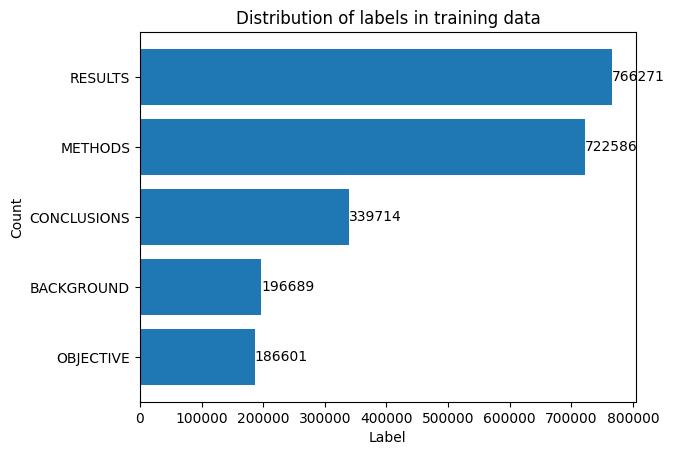

In [ ]:
barh = plt.barh(distribution.index, distribution.values)
plt.title('Distribution of labels in training data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.gca().invert_yaxis()
plt.bar_label(barh)
plt.show();

#### 2. List of Sentences

In [ ]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(2211861, 28932, 29493)

In [ ]:
train_sentences[:10]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .',
 'participants will access the program for a minimum of @ minutes per week over seven weeks .',
 'primary outcomes are domain sp

#### 3. List of sentences with characters split with ' ' (whitespace)

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

147.82646377869133

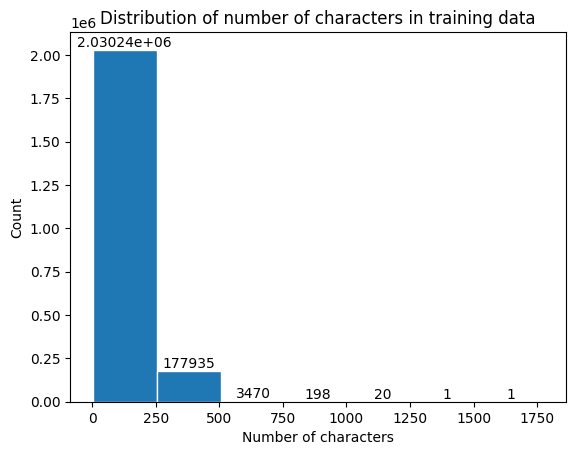

In [ ]:
values, bins, bars = plt.hist(char_lens, bins=7, edgecolor='white');
plt.title('Distribution of number of characters in training data')
plt.xlabel('Number of characters')
plt.ylabel('Count')
plt.bar_label(bars)
plt.show();

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .',
 't h i s   p a p e r   d e s c r i b e s   t h e   d e s i g n   a n d   e v a l u a t i o n   o f   p o s i t i v e   o u t l o o k   ,   a n   o n l i n e   p r o g r a m   a i m i n g   t o   e n h a n c e   t h e   s e l f - m a n a g e m e n t   s k i l l s   o f   g a y   m e n   l i v i n g   w i t h   h i v   .',
 't h i s   s t u d y   i s   d e s i g n e d   a s   a   r a n d o m i s e d   c o n t r o l l e d   t r i a l   i n   w h i c h   m e n   l i v i n g   w i t h   h i v   i n   a u s t r a l i a   w i l l   b e   a s s 

#### 4. List of Label-enocded labels

#### 4. List of numeric labels

##### a. One-hot-encoding

In [ ]:
one_hot_encoder = OneHotEncoder(sparse_output=False) # We want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))


# Check what one hot encodd labels look like
train_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

##### b. Label-encoded

In [ ]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# check what training labels look like
train_labels_encoded[:10]

array([0, 0, 2, 2, 2, 2, 2, 2, 2, 1])

#### 5. One-hot-encoded of feature-engineered features
The data is already feature-engineered with line number and total number of lines. Let's one hot encode them.

However, one-hot-encoding is very inefficient since it increases the size of the data a lot. Therefore, let's adjust the depth of the one-hot encoding to gather 98% of the data.*italicized text*

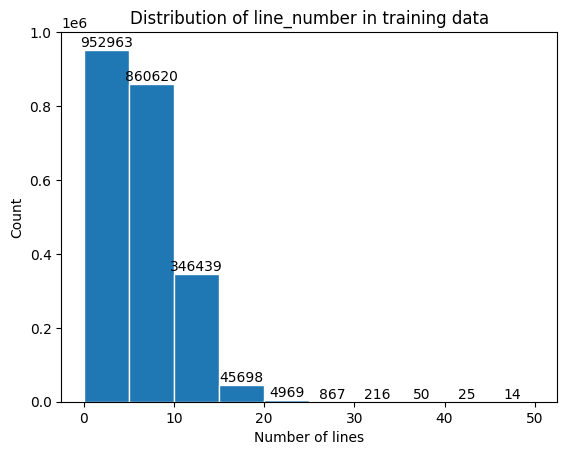

In [ ]:
# Check the distribution of 'line_number' column
values, bins, bars = plt.hist(train_df.line_number, edgecolor='white')
plt.title('Distribution of line_number in training data')
plt.xlabel('Number of lines')
plt.ylabel('Count')
plt.bar_label(bars)
plt.show();

In [ ]:
print(f'To get 95% of data we need to categorize the data to {int(np.percentile(train_df.line_number, 95))} categories')
print(f'To get 97% of data we need to categorize the data to {int(np.percentile(train_df.line_number, 97))} categories')
print(f'To get 98% of data we need to categorize the data to {int(np.percentile(train_df.line_number, 98))} categories')

To get 95% of data we need to categorize the data to 13 categories
To get 97% of data we need to categorize the data to 14 categories
To get 98% of data we need to categorize the data to 15 categories


In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape


(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([2211861, 15]))

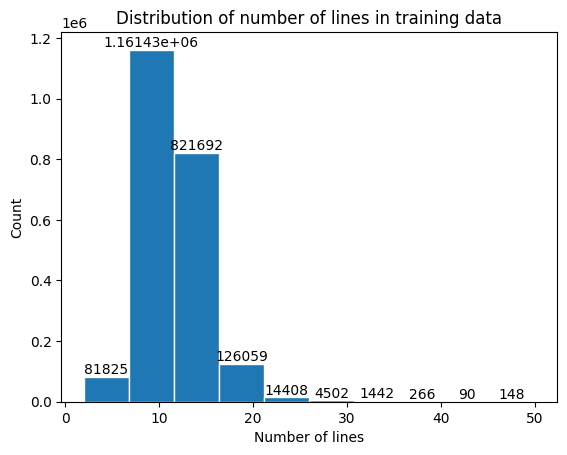

In [ ]:
# Let's check the length of different lines
values, bins, bars = plt.hist(train_df.total_lines, edgecolor='white')
plt.title('Distribution of number of lines in training data')
plt.xlabel('Number of lines')
plt.ylabel('Count')
plt.bar_label(bars)
plt.show();

In [ ]:
print(f'To get 95% of data we need to categorize the data to {int(np.percentile(train_df.total_lines, 95))} categories')
print(f'To get 97% of data we need to categorize the data to {int(np.percentile(train_df.total_lines, 97))} categories')
print(f'To get 98% of data we need to categorize the data to {int(np.percentile(train_df.total_lines, 98))} categories')

To get 95% of data we need to categorize the data to 17 categories
To get 97% of data we need to categorize the data to 19 categories
To get 98% of data we need to categorize the data to 20 categories


In [ ]:
# Use TensorFlow to create one-hot-enocded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([2211861, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 

### Saving all data

In [ ]:
parent_dir = '/content/drive/MyDrive/ColabNotebooks/projects/SciDigest/data'
data_types = ['train', 'val', 'test']
os.makedirs(parent_dir, exist_ok=True)

# 1. General dataset
save_data([train_df, val_df, test_df], parent_dir, 'general_200k', data_types)


# 2. List of sentences
save_data([pd.DataFrame(train_sentences), pd.DataFrame(val_sentences), pd.DataFrame(test_sentences)], parent_dir, 'sentences_200k', data_types)


# 3. List of sentences with characters split with ' ' (whitespace)
save_data([pd.DataFrame(train_chars), pd.DataFrame(val_chars), pd.DataFrame(test_chars)], parent_dir, 'sentences_chars_200k', data_types)


# 4. List of Label-enocded labels
#   * One-hot-encoded
save_data([pd.DataFrame(train_labels_one_hot), pd.DataFrame(val_labels_one_hot), pd.DataFrame(test_labels_one_hot)], parent_dir, 'ohe_labels_200k', data_types)
#   * Label-enocded
save_data([pd.DataFrame(train_labels_encoded), pd.DataFrame(val_labels_encoded), pd.DataFrame(test_labels_encoded)], parent_dir, 'le_labels_200k', data_types)

# 5. One-hot-encoded of feature-engineered features
#   * Line numbers
save_data([pd.DataFrame(train_line_numbers_one_hot), pd.DataFrame(val_line_numbers_one_hot), pd.DataFrame(test_line_numbers_one_hot)], parent_dir, 'line_numbers_200k', data_types)
#   * Total lines
save_data([pd.DataFrame(train_total_lines_one_hot), pd.DataFrame(val_total_lines_one_hot), pd.DataFrame(test_total_lines_one_hot)], parent_dir, 'total_lines_200k', data_types)